In [37]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls '/content/gdrive/MyDrive/datasets/alpaca_index_minor'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data.yaml  test  train	valid


## Hyperparameters and Constants

Here, we define wether to train the model or not and for how many epochs to train for.

If `TRAIN = False`, then the last trained model will be used for inference in the notebook if run end to end.

In [40]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 25

The original data had two instances of each image and label file. The rest of the code in the above block deletes the duplicate image and it's corresponding text file containing the label.

The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains 1 class: **'Alpaca'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['lpaca']
```

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images.

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [ ]:
class_names = ['Alpaca']
colors = np.random.uniform(0, 255, size=1)

In [41]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [42]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [54]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    !pwd
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        print(all_training_images[j])
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

/content
./gdrive/MyDrive/datasets/alpaca_index_minor/train/images/88d594153aef65f1.jpg
./gdrive/MyDrive/datasets/alpaca_index_minor/train/images/83b4c57707e97640.jpg
./gdrive/MyDrive/datasets/alpaca_index_minor/train/images/142351948881a71b.jpg
./gdrive/MyDrive/datasets/alpaca_index_minor/train/images/67ea47eb48a3ec97.jpg


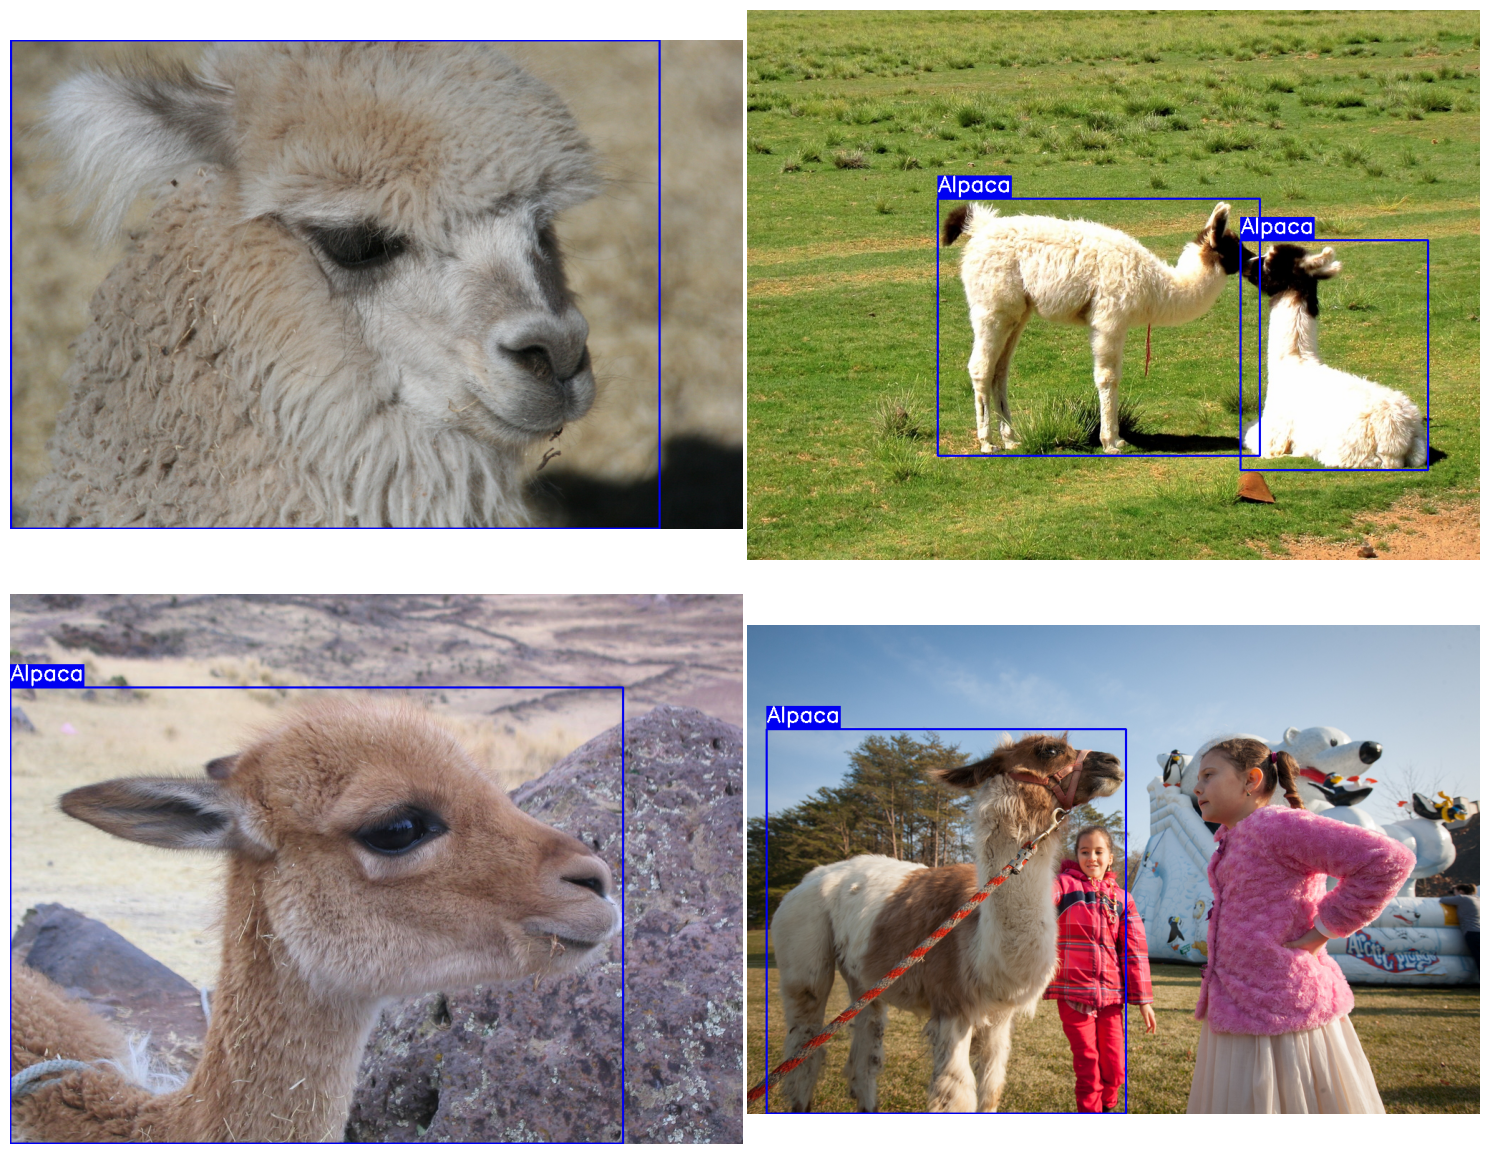

In [56]:
# Visualize a few training images.
plot(
    image_paths='./gdrive/MyDrive/datasets/alpaca_index_minor/train/images/*',
    label_paths='./gdrive/MyDrive/datasets/alpaca_index_minor/train/labels/*',
    num_samples=4,
)

## Clone YOLOV5 Repository

In [ ]:

%cd /content
!pwd

if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git



In [59]:


%cd yolov5/
!pwd

!pip install -r requirements.txt


## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [ ]:
%cd yolov5/
!pwd

In [ ]:
!pip install -r requirements.txt

## Training using YOLOV5

The next step is to train the neural network model.

### Train a Small (yolov5s) Model

Training all the layers of the small model.

In [ ]:
monitor_tensorboard()

In [ ]:
RES_DIR = set_res_dir()
print(RES_DIR)

%cd /content/yolov5
!pwd

%cd ../gdrive/MyDrive/datasets/alpaca
!pwd

%cd /content/yolov5
!pwd

!python train.py --data ../gdrive/MyDrive/datasets/alpaca/data.yaml --weights yolov5s.pt \
   --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

#if TRAIN:
#   !python train.py --data ../data.yaml --weights yolov5s.pt \
#   --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of images and videos.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [ ]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them.

In [ ]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

In [ ]:
show_valid_results(RES_DIR)